In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Ipynb_importer
from utils_x import *
from parameters_x import *
import seaborn as sns
sns.set(style="darkgrid")

importing Jupyter notebook from utils_x.ipynb
importing Jupyter notebook from parameters_x.ipynb


In [2]:
print("------------------- load data--------------------")
data = pd.read_csv('index500_v3_adjustment.csv')

print("------------------- limit_tag--------------------")
gb = data.groupby(['unique_symbol'])['adjustment_cumsum']
data['t+1_adjustment_cumsum'] = gb.transform(lambda x: x.shift(-1))
data["limit_tag"]  = (data["t+1_open"] - data["t+1_adjustment_cumsum"] + data["adjustment_cumsum"]) /data["close"] -1
data["limit_tag"] = data["limit_tag"].apply(lambda x: 1 if x >= 0.09 else 0)

------------------- load data--------------------
------------------- limit_tag--------------------


In [3]:
print("---------------- stationary pre--------------------")
data["r"] = data["close"]/ data["open"] - 1
data["amplitude"] = (data["high"] - data["low"]) / data["close"]
# data["amplitude_ratio"] = (data["high"] - data["low"]) / (data["close"] - data["open"])
# gb = data.groupby(['date_time'])['open']
# data['open_stationary'] = gb.transform(lambda x: (x-x.mean())/x.std())
# gb = data.groupby(['date_time'])['close']
# data['close_stationary'] = gb.transform(lambda x: (x-x.mean())/x.std())
# gb = data.groupby(['date_time'])['turnover']
# data['turnover_stationary'] = gb.transform(lambda x: (x-x.mean())/x.std())
# gb = data.groupby(['date_time'])['volume']
# data['volume_stationary'] = gb.transform(lambda x: (x-x.mean())/x.std())


gb = data.groupby(['date_time'])['open']
data['open'] = gb.transform(lambda x: (x-x.mean())/x.std())
gb = data.groupby(['date_time'])['close']
data['close'] = gb.transform(lambda x: (x-x.mean())/x.std())
gb = data.groupby(['date_time'])['turnover']
data['turnover'] = gb.transform(lambda x: (x-x.mean())/x.std())
gb = data.groupby(['date_time'])['volume']
data['volume'] = gb.transform(lambda x: (x-x.mean())/x.std())

print(data)
del data["Unnamed: 0"]
time_series = list(sorted(set(list(data.date_time))))
n_shift = 15
n_adjustment = []
for i in range(1,n_shift):
    n_adjustment.append("adjustment_cumsum"+str(i))

n_use_f = set(np.array(['unique_symbol', 'date_time', 't+1_open','t+2_open', 'return', 'label', 'rank_label', "use_tag", "adjustment"
                        ,'t+2_adjustment', "y_open", "adjustment_cumsum", 't+1_adjustment_cumsum']))
n_use_f = n_use_f | set(n_adjustment)
use_f = list(set(np.array(data.columns)) - n_use_f)
print(sorted(use_f))
print(len(use_f))

---------------- stationary pre--------------------
        Unnamed: 0  unique_symbol   date_time     close  turnover      open  \
0                2         600189  2010-01-29 -0.603449 -0.707479 -0.594755   
1                3         600190  2010-01-29 -1.070916 -0.728261 -1.058792   
2                4         600191  2010-01-29 -0.753797 -0.526521 -0.749434   
3                5         600192  2010-01-29 -0.454366 -0.691220 -0.447811   
4                7         600195  2010-01-29  1.179240  1.273629  1.109288   
...            ...            ...         ...       ...       ...       ...   
904764     4561421         300039  2017-12-27 -0.606519 -0.473379 -0.602659   
904765     4561425         300043  2017-12-27 -0.607750 -0.466989 -0.603875   
904766     4561435         300001  2017-12-27 -0.144030 -0.410208 -0.162052   
904767     4561436         300002  2017-12-27 -0.608366 -0.402510 -0.609952   
904768     4561481            960  2017-12-27 -0.201918  0.368563 -0.211886   


In [4]:
# plt.hist(data["volume2"],bins=100)
data["volume2"]

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
904764    1.450115
904765    1.754933
904766    0.823720
904767    1.195996
904768    0.466636
Name: volume2, Length: 904769, dtype: float64

In [5]:
all_re = []
all_pre = []
all_real_label = []
all_market_return = []
all_te_time = []
all_turn = []
all_nums_p_return = []
all_nums_return = []
all_market_return_list =[]
all_limit_tag_list = []
all_time_list = []

data = data.dropna(how='any',axis=0) 
data = data[~data['return'].isnull()].copy()
print(len(data))
      
print("-------------------- train -----------------------")
for i in range(1):
    year = 2010+i
#     print(year)
#     tr_time = select_year(str(year), time_series) + select_year(str(year+1), time_series) + \
#               select_year(str(year+2), time_series) + select_year(str(year+3), time_series) + select_year(str(year+4), time_series)
#     te_time =   select_year(str(year+5), time_series) + select_year(str(year+6), time_series) + select_year(str(year+7), time_series)
    tr_time = select_year(str(year), time_series) + select_year(str(year+1), time_series) + select_year(str(year+2), time_series)
    te_time = select_year(str(year+3), time_series)
    fin_te_time = select_year(str(year+4), time_series)
    print(len(tr_time))
    print(len(te_time))
    print(len(list(set(tr_time)-set(te_time))))
    data_tr = data[data["date_time"].isin(tr_time)].copy()
    data_te = data[data["date_time"].isin(te_time)].copy()
    data_fin = data[data["date_time"].isin(fin_te_time)].copy()
    print(len(set(data_tr["date_time"])))
    print(len(set(data_te["date_time"])))
    X_train = data_tr[use_f]
    y_train = data_tr['label']
    X_test = data_te[use_f]
    y_test = data_te['label']

    market_return = list(data[data["date_time"].isin(list(data_fin.date_time))].groupby(['date_time'])['return'].mean())
    bst = train_op(X_train, y_train, params, num_rounds, X_test, y_test, early)  # 进行训练
    importance_dic = f_importance(bst, use_f)
    re, pre, real_label, turn, nums_p_return, nums_return, market_return_list, limit_tag_list, time_list = \
       simple_re_wheeled(data_fin, use_f, bst, version='long')
    
    all_re = all_re + re
    all_pre = all_pre + pre
    all_real_label = all_real_label + real_label
    all_market_return = all_market_return + market_return
    all_te_time = all_te_time + list(sorted(set(list(data_te['date_time']))))
    all_turn = all_turn + turn
    all_nums_p_return = all_nums_p_return + nums_p_return
    all_nums_return = all_nums_return + nums_return
    all_market_return_list = all_market_return_list + market_return_list
    all_limit_tag_list = all_limit_tag_list + limit_tag_list
    all_time_list = all_time_list + time_list
    print(len(all_turn))
    print(len(all_te_time))


896679
-------------------- train -----------------------
710
238
710
696
238


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-rmse:1.00356	eval-rmse:1.01418
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[1]	train-rmse:0.970517	eval-rmse:0.980531
[2]	train-rmse:0.953523	eval-rmse:0.963429
[3]	train-rmse:0.944873	eval-rmse:0.954664
[4]	train-rmse:0.940227	eval-rmse:0.949739
[5]	train-rmse:0.937352	eval-rmse:0.947072
[6]	train-rmse:0.935821	eval-rmse:0.945656
[7]	train-rmse:0.934689	eval-rmse:0.944753
[8]	train-rmse:0.933839	eval-rmse:0.944296
[9]	train-rmse:0.933117	eval-rmse:0.943863
[10]	train-rmse:0.932562	eval-rmse:0.943568
[11]	train-rmse:0.931759	eval-rmse:0.943246
[12]	train-rmse:0.931367	eval-rmse:0.943137
[13]	train-rmse:0.930965	eval-rmse:0.942976
[14]	train-rmse:0.930284	eval-rmse:0.942791
[15]	train-rmse:0.929744	eval-rmse:0.942703
[16]	train-rmse:0.929275	eval-rmse:0.942602
[17]	train-rmse:0.928888	eval-rmse:0.942538
[18]	train-rmse:0.928515	eval-rmse:0.942483
[19]	train-rmse:0.928046	eval-rms

###############################################
[600180, 600038, 600161, 600261, 600195, 415, 600685, 600557, 600563, 600640, 600612, 600570, 600673, 600835, 600978, 601126, 88, 413, 541, 511, 636, 829, 848, 962, 939, 997, 2041, 2028, 2048, 2008, 2005, 2123, 2183, 2277, 2281, 2283, 2327, 2293, 2332, 2315, 2368, 2410, 2698, 2557, 2574, 2663, 2635, 2638, 600503]
0.0002460527695315131 2014-01-10
[ 0.03647416 -0.00566038 -0.02845528  0.06206897 -0.0286113   0.00274725
 -0.019375    0.02449223  0.00322135  0.02300696 -0.02264493 -0.01814301
  0.00107527  0.02842704 -0.02777778  0.00675676 -0.01576182 -0.01055556
  0.01496259  0.01785714  0.         -0.01335312 -0.01793103  0.0042328
 -0.00168919 -0.01021711 -0.0063593   0.01408451  0.03073286 -0.00533537
 -0.00769231  0.00835655 -0.01457726  0.06122449  0.         -0.00927644
 -0.02189781 -0.02183406 -0.00148368  0.02643678 -0.05125076  0.00934288
  0.05693161 -0.02580645  0.00482859 -0.02985075 -0.03851333  0.01456311
  0.01428571]
#######

###############################################
[600094, 600021, 600320, 600117, 488, 600366, 600284, 600280, 600482, 600468, 600557, 600120, 600640, 600612, 513, 600829, 600884, 601100, 601339, 601515, 600872, 600869, 21, 31, 409, 415, 600864, 726, 780, 600500, 939, 962, 973, 2223, 2219, 2233, 2262, 2281, 2266, 2305, 2306, 2325, 2414, 2429, 2437, 2419, 2470, 2678, 600491]
0.0050537065484448996 2014-01-24
[ 0.         -0.03846154  0.0060423  -0.01152738  0.          0.00518519
  0.04950495 -0.01990446  0.01646091  0.00098135  0.01949861  0.0090312
  0.01315193 -0.00852713  0.03924794  0.00152672  0.00153728 -0.02252252
 -0.00408163 -0.01957295  0.03043478  0.02769679  0.03807947  0.01724138
 -0.00309119  0.0215311  -0.00237812  0.0041365   0.01222494 -0.02089136
 -0.01444623 -0.009       0.          0.02925244  0.02920255 -0.01151316
 -0.00369004  0.00362319 -0.01098901 -0.00933126  0.0754717  -0.07692308
  0.00940695  0.01508485  0.02866894  0.01678184  0.02181818  0.00645161
 -0.0147

###############################################
[600180, 600110, 600161, 600280, 513, 600765, 600337, 600487, 600685, 600458, 600563, 600570, 600425, 600387, 600594, 601002, 601208, 601311, 600510, 601216, 601908, 413, 21, 49, 78, 566, 488, 732, 719, 921, 997, 998, 2013, 2122, 2153, 2315, 2262, 2281, 2277, 2416, 2410, 2508, 2701, 2489, 2490, 2601, 2690, 600517]
0.019401428512595336 2014-02-14
[ 0.03751914  0.01098901 -0.00140977  0.04511834 -0.00947149  0.03456402
  0.02190923  0.03207547  0.0335642  -0.00302115  0.0537514  -0.00873965
  0.          0.01478084  0.0503792  -0.00923788  0.00363636  0.0329582
  0.00172117  0.01763908  0.03479237  0.03636364  0.01481481 -0.00269008
  0.00770218 -0.01776199  0.01746725 -0.00721649  0.01591896  0.02631579
  0.03007916  0.00276352  0.06178764  0.01635514  0.00339271  0.0342339
  0.          0.03880914  0.00724638  0.01385165  0.08456132  0.0218108
 -0.00580046  0.03763441  0.01548673  0.00494234  0.0610984   0.01858363]
######################

###############################################
[600054, 600158, 600183, 600161, 600261, 525, 600240, 600351, 600335, 600488, 600584, 600551, 600580, 600380, 600636, 600645, 600723, 600759, 600835, 600773, 600850, 601388, 587, 603, 671, 777, 600537, 987, 2083, 2063, 2049, 2152, 2179, 2194, 2281, 2424, 2340, 962, 2392, 2368, 2416, 2440, 2461, 2503, 2690, 2698, 600531, 2663]
0.01789776346685731 2014-02-28
[ 0.00832639 -0.00115207  0.01694915  0.01038961  0.02012195  0.01146132
  0.02546296  0.04381443  0.01152436  0.00464037  0.01149425  0.00393258
 -0.01518987  0.02661597  0.07196262  0.0507053   0.04905063  0.04294479
 -0.0044335   0.01456816 -0.00143472  0.03549061 -0.01644245  0.01055807
 -0.00547945  0.02390671  0.02627258  0.02725367  0.         -0.00409091
 -0.00361174  0.042       0.00353982  0.01754386  0.00713267  0.00840336
  0.01769912  0.02076843  0.01668653  0.08959538  0.02064897  0.04425711
  0.01119403  0.01130856  0.02352941  0.00877193  0.00520833  0.01519337]
########

###############################################
[600132, 600261, 600312, 600198, 600200, 600408, 600392, 600397, 600468, 600418, 600458, 600478, 600021, 603001, 600570, 600628, 600654, 600657, 600702, 600826, 600884, 418, 525, 517, 540, 559, 603, 671, 2154, 712, 982, 2091, 973, 2029, 2123, 2140, 2237, 2181, 2281, 2306, 2271, 2414, 2384, 2400, 2424, 2493, 2503, 777]
0.026681377127134864 2014-03-14
[ 0.01906059  0.0167364   0.04566929  0.00280899  0.03885291  0.016
 -0.009375    0.01424501  0.02325581  0.10879121  0.01689189 -0.0090535
  0.01059322  0.00848564  0.09991533  0.03512623  0.03415783  0.03498542
  0.02323651  0.01182197  0.07988166  0.0212766   0.00769231  0.01446281
  0.00798403  0.04744186  0.00083264  0.01125     0.02120718  0.0070922
  0.04716981  0.0560054   0.04571429  0.04463209  0.04150943  0.02125399
 -0.01045296  0.05018138  0.03666874  0.0234375   0.00271003  0.05108696
 -0.01414879  0.02634593  0.05331705  0.00664452  0.03234501  0.00495868]
######################

###############################################
[600006, 600069, 600056, 600078, 600645, 600158, 600162, 600171, 600322, 600409, 600551, 600563, 600639, 600699, 600748, 600787, 600825, 600880, 600884, 600983, 601588, 601965, 78, 510, 511, 541, 559, 631, 726, 732, 759, 1696, 2004, 2153, 2275, 2285, 2292, 2309, 2315, 2325, 2345, 2368, 2384, 2396, 2414, 2440, 2463, 2635]
-0.0042249794422301755 2014-03-28
[-0.00980392 -0.01044386 -0.01116071  0.00362319 -0.02928199  0.01447527
  0.00689655 -0.00383142 -0.02493075 -0.01212121  0.01145767  0.02224053
 -0.04295051  0.02673797 -0.03733333  0.01055807 -0.05543478 -0.00917431
  0.017067   -0.00953778 -0.01449275 -0.05142857 -0.01468788 -0.01785714
 -0.00773694  0.05112474  0.00421941  0.00988142 -0.01829925  0.03108808
  0.0155642   0.01388889 -0.01788806 -0.05563218  0.00787879 -0.02513966
  0.03400204 -0.01001112 -0.00428894 -0.00659341  0.01131222 -0.00975149
 -0.0200747  -0.02631579 -0.00355872  0.06227106 -0.01404494  0.01672003]
##########

###############################################
[600158, 600239, 600298, 600397, 600422, 600401, 600509, 600482, 600470, 600551, 600614, 600645, 600673, 600743, 600747, 600770, 600801, 600894, 603077, 28, 50, 418, 415, 600268, 587, 671, 655, 732, 823, 921, 935, 2004, 2022, 2048, 2123, 2078, 2154, 2168, 2219, 2249, 2252, 2414, 2477, 2493, 2482, 2572, 2678, 2698]
-0.0055568769811232014 2014-04-14
[ 0.05560882 -0.00616016 -0.00556931  0.00968523  0.          0.00941176
 -0.03096774 -0.01577564 -0.02073365 -0.02413793  0.07035176 -0.02372035
  0.00514139 -0.02034884  0.06       -0.01328273 -0.0415004  -0.01860119
 -0.02100271  0.02249891 -0.01033973 -0.02051282 -0.01401869 -0.01270417
 -0.01007752 -0.02489177 -0.02564103  0.00300903 -0.03070539 -0.0021164
 -0.01075269 -0.03119777 -0.00042373  0.00716561 -0.0037831  -0.02538787
  0.0015873  -0.00404858 -0.00445525  0.02831595  0.00290909 -0.02941176
  0.04329004 -0.01005587 -0.03437095  0.00502793 -0.01752336 -0.02651379]
##################

###############################################
[600073, 600094, 600122, 600139, 600220, 600270, 600329, 600325, 600335, 600351, 600425, 600422, 600499, 600545, 600563, 600587, 600614, 600636, 600639, 600596, 600673, 600699, 600724, 600797, 601000, 601233, 49, 90, 511, 572, 559, 620, 669, 877, 1696, 2050, 997, 2118, 2181, 2191, 2249, 2254, 2276, 2424, 2440, 2572, 2635, 2690]
0.025094598277912928 2014-04-28
[ 0.01269394  0.02        0.01972387  0.01415094  0.05244755  0.03989813
  0.00080064 -0.04269972  0.01468531  0.0230179   0.08872902  0.01126761
  0.04651163  0.0748731   0.05810056  0.02170922  0.00808081  0.04242928
  0.01296296 -0.01966292  0.04113111  0.01734104  0.02222222  0.01795332
 -0.0125     -0.03648425  0.04166667  0.01568627  0.04166667  0.02717391
  0.03033708  0.02295082  0.02413793  0.04615385  0.01004016  0.03650794
  0.01412067  0.04454685  0.01826793  0.02297999  0.01114923  0.04097453
  0.02614379  0.02284012  0.02224576  0.02026599  0.06875     0.0465513 ]
#####

###############################################
[780, 600110, 600162, 600139, 600251, 600740, 600322, 600456, 600387, 600388, 600510, 600508, 600584, 600618, 600616, 600643, 600724, 600657, 600723, 600815, 600507, 601908, 28, 413, 603, 671, 669, 600499, 829, 962, 2041, 2075, 2118, 2203, 2191, 2219, 2262, 2273, 2340, 2332, 2371, 2400, 2428, 2444, 2480, 2635, 2638, 2574]
-0.020308768434368952 2014-05-14
[-0.02948403 -0.02584493 -0.02734375  0.05486726 -0.00198282 -0.0310219
 -0.02409639 -0.00813008 -0.05734767 -0.01857324 -0.01869159 -0.02314251
 -0.04086845 -0.03169014 -0.00946746 -0.01812689 -0.03317536 -0.02077151
 -0.00963082  0.03542234  0.          0.01818182 -0.04394737  0.01103753
 -0.04136691  0.00837321 -0.01444867 -0.00510204 -0.02631579 -0.01565996
 -0.01829268 -0.02046036  0.01481481 -0.07258687 -0.02086331 -0.08014667
 -0.02639175 -0.03009135 -0.008      -0.02151899 -0.0070922  -0.01152881
  0.00851064 -0.05932203 -0.034375   -0.04603714 -0.02022472 -0.07286634]
###########

###############################################
[600039, 600064, 600300, 600094, 600200, 600239, 600456, 600458, 600438, 600435, 600467, 600469, 600478, 600482, 600487, 600702, 600829, 600894, 600983, 601100, 601010, 601233, 601616, 601636, 30, 517, 513, 600750, 697, 712, 759, 900, 2022, 2025, 2049, 2153, 2154, 2140, 2181, 2327, 2447, 2534, 2508, 2490, 2601, 2498, 2662, 600500]
-0.013108598750638953 2014-05-28
[ 0.00185529 -0.0058309  -0.00502513 -0.01644737 -0.00378072 -0.01538462
 -0.01731928 -0.0183908  -0.00788288 -0.00963222 -0.00770713 -0.01146789
 -0.00203666 -0.01384768 -0.02915452 -0.0198556   0.         -0.01731996
  0.01792382 -0.01616379 -0.02028986 -0.01284404 -0.01612903 -0.01751825
 -0.01401869 -0.02713987 -0.00110375 -0.01127113 -0.02099076  0.00154321
 -0.01551313 -0.00157978 -0.01081081 -0.02255639 -0.01638298 -0.03
 -0.0199005  -0.02150538 -0.06323877  0.01083032 -0.00709607 -0.01785714
  0.00656168 -0.02354399 -0.02848837 -0.02620087 -0.00470035  0.        ]
#######

###############################################
[600580, 600171, 600180, 600277, 600284, 600456, 600507, 600508, 600429, 600488, 600335, 600425, 600743, 600729, 600797, 426, 601100, 601010, 601126, 31, 66, 600197, 418, 413, 608, 572, 541, 669, 848, 822, 829, 2050, 921, 738, 719, 697, 2011, 2281, 2368, 2410, 2508, 2498, 631, 2690, 2698, 2447, 2489, 977]
0.013528133280944142 2014-06-12
[ 0.09489051  0.0237069   0.01935484 -0.00746269  0.00204918 -0.01433447
  0.00314465  0.01413882  0.00832178  0.00240964  0.03571429 -0.00904159
  0.0034965   0.01658291 -0.00588235 -0.01904762 -0.00324675  0.02526003
  0.01256106  0.00917431  0.0097561   0.00327869  0.01014199  0.00736196
  0.          0.01133144  0.00623701  0.00346821  0.01042209  0.02033898
  0.00887902  0.01152738  0.02040816 -0.00171674  0.00865052  0.0907563
  0.01787995 -0.00467153  0.02794163  0.03103587  0.00305085  0.01605839
 -0.00224215  0.02556653 -0.00192753  0.00698925  0.02158273  0.07545533]
#############################

###############################################
[600161, 600132, 600537, 600180, 600557, 600280, 600277, 2612, 600618, 600640, 600635, 600683, 600351, 600373, 600401, 600773, 600797, 600841, 601216, 600983, 601339, 6, 30, 550, 541, 601965, 822, 823, 2315, 2309, 777, 2008, 931, 759, 2028, 2320, 2226, 2249, 2181, 2396, 2275, 2368, 2371, 2153, 2345, 2498, 2429, 2477]
0.010645123753904357 2014-06-26
[ 0.00331492  0.00335345  0.01081613  0.03143418  0.01295518  0.04271632
  0.00155039  0.00253165  0.00548697  0.00955795  0.02118644  0.00821355
  0.00549451 -0.01732852  0.05620915 -0.00704225  0.0149925  -0.00610998
 -0.00478469 -0.01171875  0.01001252 -0.01910828  0.03448276 -0.00746522
  0.0244898   0.03361345  0.00323625  0.01954121  0.03253012  0.00170551
  0.03727866  0.          0.00192308  0.01522843  0.01078749  0.03372093
  0.05571848  0.03384615  0.0316129  -0.01433692  0.00865513 -0.01425538
  0.02153361 -0.01764706 -0.00552486  0.0170697  -0.02264151  0.00212993]
################

###############################################
[600335, 600584, 600580, 600280, 600521, 2648, 600651, 600618, 600639, 600551, 600366, 600429, 600748, 600801, 510, 600815, 2612, 601012, 600737, 50, 603077, 601965, 697, 671, 669, 823, 2311, 777, 788, 2075, 919, 719, 2018, 2194, 2225, 2249, 2396, 2320, 2342, 2152, 2153, 2503, 2698, 2480, 2437, 977, 979, 2005]
0.012419221288732954 2014-07-10
[-0.01167076  0.          0.0263789   0.05605606 -0.00174672  0.01188811
  0.05756359  0.0282638  -0.00294695  0.00059559 -0.04823529  0.00135318
  0.00933333 -0.00146199  0.04689864  0.          0.01339713  0.00398936
  0.03157895  0.01891253  0.00149031 -0.01172529  0.02684564  0.02828283
  0.01558302  0.00590717 -0.01125541  0.02034884  0.00514286  0.02030457
  0.01815431 -0.00082645  0.03496503  0.02141158  0.06591337  0.00814815
  0.01439939  0.01336303  0.01065719  0.00825959 -0.00106838  0.00457143
  0.          0.02043597 -0.00703971  0.00719424  0.0304878   0.0060241 ]
#######################

###############################################
[600161, 600337, 600171, 600481, 600479, 600510, 600636, 600612, 600429, 600425, 600366, 600651, 600410, 600825, 600748, 600803, 511, 600850, 600790, 600884, 600967, 600970, 600983, 66, 601777, 417, 650, 848, 809, 2308, 712, 719, 2018, 2041, 2011, 2190, 2281, 2358, 2405, 2340, 987, 2534, 2437, 2424, 2479, 973, 962, 997]
0.011952486420151516 2014-07-24
[ 0.01641791  0.00838926  0.01435407  0.0101626   0.00502513 -0.00174216
  0.00732064 -0.00436047  0.00138122  0.03125     0.04914286  0.03723404
  0.07142857  0.00126743  0.01756587 -0.00240385  0.02609727  0.03288032
  0.01815824 -0.00361944  0.          0.00273598  0.05311077  0.01569507
 -0.00361011  0.02554745  0.02016129  0.01315789 -0.00433526  0.00985915
  0.02483221  0.00840336 -0.01044084  0.01390374  0.01242236  0.03321033
  0.00728376 -0.01385681 -0.01165644  0.01702128  0.          0.00930954
 -0.02744739  0.00076953  0.00773196  0.00340136  0.00671141  0.02384824]
#############

###############################################
[600088, 600584, 600537, 600329, 600175, 600187, 600268, 600468, 600525, 2662, 669, 600618, 600651, 541, 600724, 600759, 600773, 600816, 600850, 600826, 600754, 600879, 601012, 600885, 600967, 601002, 601233, 66, 601801, 603766, 631, 550, 603, 587, 693, 927, 1696, 732, 2029, 2025, 2249, 2285, 2267, 2276, 2358, 2534, 2678, 2489, 2477]
0.01173396842954017 2014-08-07
[ 0.01865672  0.001002    0.02459712  0.00348432  0.06386293  0.03214286
  0.00652529  0.00353669 -0.01616815  0.01698514  0.02908163  0.01930036
  0.003861    0.01740812 -0.0045977   0.01163832 -0.0048     -0.00460035
  0.05498564  0.02255193 -0.00283286  0.02325581 -0.00056818  0.01097454
  0.04169515  0.00197433 -0.01183432  0.06827309  0.02054795  0.01226994
  0.01607143 -0.00879321 -0.01131626  0.01916376 -0.02858362  0.04845815
  0.00601202  0.01541624  0.          0.01186178 -0.02083333  0.0125261
  0.021      -0.00941176  0.04652827  0.00075472  0.01254276  0.00345722
 -

###############################################
[600171, 600587, 600180, 600054, 600266, 600468, 600482, 2601, 600645, 600580, 600397, 600651, 600835, 600803, 566, 600864, 601233, 601801, 6, 510, 559, 426, 418, 612, 759, 762, 685, 2315, 951, 927, 962, 2041, 2122, 2161, 2219, 2233, 2254, 2332, 2273, 2277, 2368, 2154, 2572, 2503, 2714, 2480, 987, 975]
0.009271147325466876 2014-08-21
[ 0.01750772  0.01028571  0.03589744 -0.04442925 -0.02682403  0.00589722
 -0.00377358  0.01079137  0.03898635 -0.00217391 -0.00604839 -0.00736196
  0.01876955  0.01859024  0.0220234   0.00342075  0.00873362 -0.01819363
  0.02607076  0.03900709  0.00740741 -0.00932203 -0.00165837  0.07244898
  0.00593824  0.00619579  0.01830863  0.02016217  0.02291667  0.00816327
 -0.0204953  -0.01178344  0.00183486  0.01174935 -0.01030043  0.0056338
  0.00380952  0.02601156  0.01970692  0.01010101  0.01573604  0.00434783
 -0.01304802  0.02995169  0.02429907  0.04631829  0.00527426 -0.00186916]
################################

###############################################
[600038, 600618, 600125, 600333, 600311, 600197, 600184, 600078, 2678, 600500, 600487, 600640, 600654, 600416, 600743, 600759, 600787, 600874, 600894, 600997, 601101, 601311, 600879, 601678, 603555, 601908, 600239, 631, 415, 671, 780, 759, 2078, 2041, 2242, 2179, 2118, 2154, 2273, 2342, 2308, 2332, 2419, 2595, 2461, 2534, 2690, 2489]
0.005866005654806582 2014-09-04
[ 0.00534125 -0.0045819   0.01413428 -0.00130208  0.00359066  0.00972763
 -0.03188496  0.0089955   0.06081081  0.00382166 -0.02484815  0.00587947
 -0.00189394  0.0330912  -0.0060423  -0.0057947  -0.00117647 -0.00347625
  0.00659341  0.00380228  0.00313972  0.0074129   0.00455729  0.01734104
 -0.00930233  0.0483871  -0.00566038  0.01184433  0.00786517  0.01111111
  0.00638298  0.02820212  0.01007557 -0.01165287  0.         -0.02169625
  0.04620253  0.04139715  0.01941309  0.01585014 -0.01218162  0.04182156
 -0.00520382 -0.00823353 -0.01672241 -0.00572246 -0.01473684 -0.00311042]

###############################################
[600161, 600176, 600110, 600335, 600266, 600261, 600260, 600184, 600197, 600510, 600467, 600545, 2672, 2662, 600490, 600487, 600500, 600702, 600566, 600639, 600429, 600754, 601801, 550, 600993, 601100, 600776, 601566, 601777, 600239, 636, 667, 688, 848, 2069, 2049, 759, 2093, 2191, 2250, 2309, 2345, 2315, 2317, 2342, 2371, 2588, 2498]
-0.012416141463853008 2014-09-19
[-0.00727273 -0.02953586 -0.00137174 -0.00238095 -0.03069307 -0.01415094
 -0.01255605  0.0062727  -0.01759531  0.00136426 -0.02247191  0.02386364
 -0.0158209   0.03476821  0.0167336  -0.01174497 -0.01273885 -0.03596127
 -0.04228756 -0.03583062  0.01637555 -0.01811249 -0.04497843 -0.02857143
 -0.02090032 -0.00364299 -0.01014199 -0.0163297  -0.01637427 -0.01880342
 -0.03019324 -0.01265823 -0.0247093  -0.02073006  0.00386598 -0.02491694
 -0.01288056  0.01771337 -0.00413793 -0.02091255 -0.03448276 -0.01404494
 -0.03161222 -0.00968992  0.00582242  0.00264901 -0.00037397 -0.0137931

###############################################
[600616, 600176, 600183, 600187, 600300, 600270, 600510, 600537, 2672, 2678, 600490, 600496, 600704, 600570, 600572, 600582, 600645, 600864, 600765, 600844, 600850, 601002, 601126, 601566, 601339, 601777, 563, 587, 786, 777, 697, 852, 975, 2049, 759, 2154, 2194, 2216, 2262, 2368, 2419, 2384, 2690, 2714, 2490, 2701, 685, 998]
0.00769756801374379 2014-10-10
[-0.00112867 -0.00399202 -0.0147651  -0.02308802 -0.00922509  0.00846354
 -0.01744966  0.01982507 -0.01332955 -0.00083963  0.0297619  -0.00878156
  0.09982487  0.01903553  0.0070922  -0.02030009 -0.01616499 -0.00422386
  0.05882353 -0.03283174  0.03094158  0.03647687  0.00993571 -0.0076864
 -0.00108108  0.01034483  0.00987654 -0.00166806 -0.00800854  0.02465753
  0.00777832  0.06114398 -0.03387221  0.01093408  0.01694915 -0.00119474
  0.01652299  0.0219152   0.03763441 -0.0264574   0.01826087  0.04520918
  0.03544601 -0.05430712  0.05787234  0.00713087  0.00813008 -0.0401084 ]
##########

###############################################
[600038, 600086, 600110, 600120, 600201, 600557, 600397, 600490, 600500, 685, 600508, 600570, 600566, 600458, 600683, 600673, 600750, 600773, 600993, 601208, 601515, 601718, 601801, 600337, 513, 652, 566, 501, 927, 2063, 2050, 2153, 2216, 2219, 2251, 2262, 2277, 2285, 2317, 2371, 2393, 2378, 2408, 2437, 2424, 2646, 2714]
0.01044680259049601 2014-10-24
[ 0.01458886  0.0139738   0.00437318  0.01390728 -0.00571592 -0.00693431
  0.          0.01225919  0.01452785 -0.00888231  0.01072961  0.00153061
 -0.0070306   0.1        -0.03354633 -0.00604839  0.00983946  0.01729819
  0.01012536  0.02484472  0.01785714  0.02660754  0.01769912  0.00361882
  0.01589061  0.02767528  0.00587889 -0.00502513  0.0034904   0.00607477
  0.01138647  0.00747283 -0.0170085   0.01        0.01189768  0.04419476
  0.00458115  0.012749    0.01810386  0.00160192  0.00812763  0.02314571
  0.00842697  0.02066116  0.02579556 -0.00174419  0.002     ]
#########################

###############################################
[600094, 600138, 600078, 600004, 600654, 600160, 600120, 600201, 600266, 600064, 600292, 600537, 600449, 2672, 600488, 600481, 600511, 600720, 600582, 600435, 600673, 600685, 600750, 600754, 600790, 600816, 600825, 600885, 601100, 601908, 563, 603077, 525, 603766, 685, 816, 809, 887, 848, 988, 973, 2029, 2122, 2179, 2305, 2408, 2573]
0.006584074684144919 2014-11-07
[-0.02208589 -0.01325967  0.01441242  0.03651987  0.00287081 -0.01464129
  0.01075912  0.00564972  0.00513259  0.01020408  0.02882306  0.01206273
  0.06536585 -0.02077151  0.00875657  0.01277372  0.02118492  0.0261661
  0.00454545 -0.02132867  0.05340454 -0.04087014  0.00691358 -0.02962963
  0.00603865 -0.02057762  0.0431338   0.          0.01552288 -0.01539708
  0.00445931  0.08595194 -0.0005711  -0.00511654  0.0261745   0.00473186
 -0.01509434 -0.00752351  0.01605058  0.01443124  0.00286533  0.01517857
  0.00137363 -0.02710623  0.01052632  0.00053191 -0.00909091]
############

###############################################
[600088, 600138, 600078, 600086, 600176, 600171, 600335, 600059, 600280, 600537, 600563, 600657, 600645, 600428, 600685, 600748, 600773, 600826, 600894, 600869, 601233, 422, 543, 550, 693, 719, 732, 861, 786, 988, 962, 2056, 2233, 2276, 2285, 2181, 2327, 2320, 2345, 2005, 2477, 2663, 2662, 2503, 2714, 2690]
0.009382213354673456 2014-11-21
[-0.03230088  0.00115075 -0.00324324  0.00203666  0.05220884  0.01367366
 -0.0035461   0.00234192  0.01422222  0.01791229 -0.00765901 -0.00869565
 -0.0377193   0.04109589  0.02631579  0.045       0.01308258  0.03829322
  0.01185185  0.01659751  0.01827676  0.00780031  0.01352875  0.00883508
  0.08959928 -0.02121212  0.04599659  0.01162791  0.03407407  0.03197442
  0.02054232 -0.00093458  0.00729927  0.00665927 -0.04490829 -0.01257143
  0.02048281 -0.00781861 -0.00691244  0.0035503  -0.00865385  0.01285714
 -0.00217391  0.00320924  0.01642276 -0.01858824]
###############################################
[6

###############################################
[600021, 600006, 600067, 600200, 600199, 600337, 600409, 600536, 600392, 600482, 600432, 600683, 600750, 600823, 600888, 600858, 600874, 601126, 601101, 601566, 601717, 603077, 600239, 90, 688, 552, 550, 655, 620, 631, 777, 887, 939, 1696, 2056, 2064, 2152, 2254, 2219, 2221, 2216, 2281, 2311, 2428, 2463, 2612]
0.01690544741787153 2014-12-05
[ 0.03546099  0.00176991  0.07859079  0.01520913  0.01105991 -0.00671141
  0.05175038 -0.00670927  0.02980427  0.03221565  0.02548167  0.04028777
  0.03255814  0.02745098  0.04203822  0.01754386  0.04446855  0.05623342
  0.01253133  0.00673653  0.07785235 -0.02068966  0.03503185  0.
 -0.01963048  0.0056872  -0.0176399   0.02051836  0.00412655  0.01886792
  0.00940439 -0.006875    0.03090909  0.0164271   0.0437788   0.02307692
 -0.00204813  0.04549675 -0.01393121  0.03267974 -0.02174941 -0.0145679
 -0.00431034  0.0192926  -0.00877193 -0.02305588]
###############################################
[600125, 

###############################################
[600337, 600266, 600416, 600570, 600517, 2678, 600496, 600239, 600755, 600787, 600757, 600805, 600811, 600997, 601099, 601801, 603001, 31, 600743, 422, 415, 417, 552, 550, 563, 652, 685, 759, 900, 927, 930, 939, 962, 997, 977, 2153, 2183, 2181, 2371, 2392, 2431, 2128, 2534, 2503, 2672]
-0.035297338072669715 2014-12-19
[-0.02443793 -0.0845815  -0.03957997 -0.08945687 -0.00729927 -0.08900145
 -0.03925845 -0.06389302 -0.07016129 -0.04761905 -0.0087146  -0.03550296
  0.00730689  0.03538663 -0.01791045 -0.02849003 -0.07536077 -0.03341902
 -0.01913876 -0.01902174 -0.06837607 -0.02351314  0.00377358 -0.01821731
 -0.02627258 -0.08535032 -0.05638767 -0.00345622 -0.04972376 -0.05571429
  0.         -0.08370044 -0.03253968 -0.04257603  0.1        -0.08988341
 -0.07035519 -0.03195266 -0.03427347 -0.08364451 -0.02539981  0.01607717
 -0.07091172 -0.01573604  0.00990693]
###############################################
[600094, 600325, 600335, 600266, 60

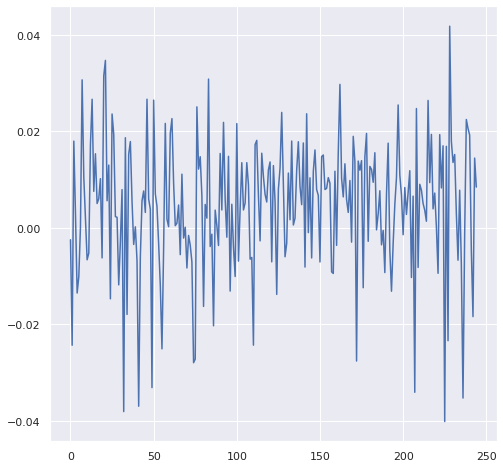

In [6]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(all_re)

In [7]:
def plot_conditional_expectation(x, y, quantile_n = 20):
    step = 1 / quantile_n
    bin_cut = np.percentile(x, list(np.append(np.arange(0,1,step), 1)*100) )
    bin_cut = np.unique(bin_cut)
    tmp = pd.DataFrame({'x':x.flatten(), 'y':y.flatten()})
    tmp['bin_cut'] = pd.cut(tmp['x'],bin_cut,include_lowest=True)
    groupby_mean = tmp.groupby('bin_cut').mean().reset_index()

    plt.figure(figsize=(12,4))
    plt.plot(groupby_mean['x'], groupby_mean['y'], '-o')
    plt.axvline(x=0, color='r', ls='-.')
    plt.axhline(y=0, color='r', ls='-.')
    plt.show()
        
    return groupby_mean

In [8]:
df_r =  pd.DataFrame({"real_nums_return":all_nums_return,\
                      "pre_nums_return":all_nums_p_return,"rank":all_real_label,\
                      "pre_rank":all_pre, "limit_tag":all_limit_tag_list,\
                      "market_return":all_market_return_list, "time_list":all_time_list})

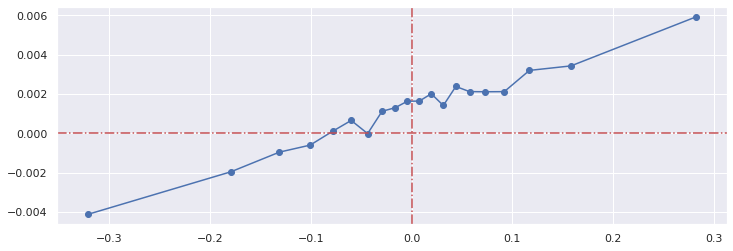

,bin_cut,x,y
0,"(-0.957, -0.216]",-0.321325,-0.004123
1,"(-0.216, -0.151]",-0.179335,-0.001958
2,"(-0.151, -0.114]",-0.131114,-0.000957
3,"(-0.114, -0.0886]",-0.100656,-0.000601
4,"(-0.0886, -0.0687]",-0.078367,0.000102
5,"(-0.0687, -0.0514]",-0.059891,0.000654
6,"(-0.0514, -0.0362]",-0.043591,-0.000015
7,"(-0.0362, -0.0226]",-0.029294,0.001118
8,"(-0.0226, -0.01]",-0.016212,0.001302
9,"(-0.01, 0.00177]",-0.004140,0.001631


In [9]:
plot_conditional_expectation(np.array(df_r["pre_nums_return"]), np.array(df_r["real_nums_return"]))

In [10]:
df_r[df_r["limit_tag"] == 1]

,real_nums_return,pre_nums_return,rank,pre_rank,limit_tag,market_return,time_list
3420,0.100334,0.333010,9.0,9,1,0.018447,2014-01-13
3529,0.099596,0.067249,9.0,7,1,0.018447,2014-01-13
5504,0.100461,-0.024802,9.0,4,1,-0.004381,2014-01-17
6045,-0.002154,0.163042,1.0,9,1,0.015456,2014-01-20
6341,0.032370,0.383773,8.0,9,1,0.024721,2014-01-21
...,...,...,...,...,...,...,...
113971,-0.085526,-0.052350,0.0,3,1,-0.013210,2014-12-26
114029,-0.064649,1.565377,0.0,9,1,-0.013210,2014-12-26
114128,0.082961,0.516502,9.0,9,1,-0.013210,2014-12-26
114321,0.080396,0.466085,9.0,9,1,-0.013210,2014-12-26


In [11]:
tdf = df_r[(df_r["pre_rank"] == 9) & ~(df_r["limit_tag"] == 1)]

In [12]:
re_limit = list(tdf.groupby(["time_list"])["real_nums_return"].mean())

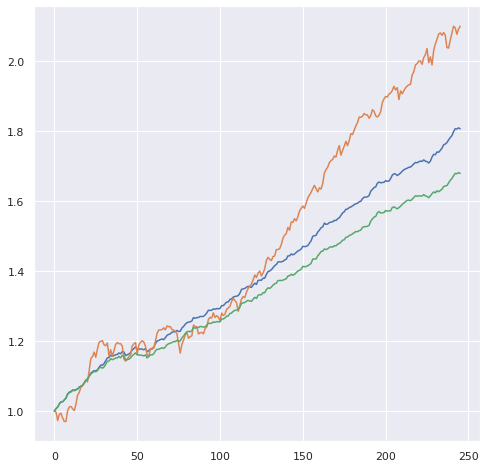

In [13]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(add_return(np.array(all_re)-np.array(market_return)))
plt.plot(add_return(np.array(all_re)))
plt.plot(add_return(np.array(re_limit)-np.array(market_return)))

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


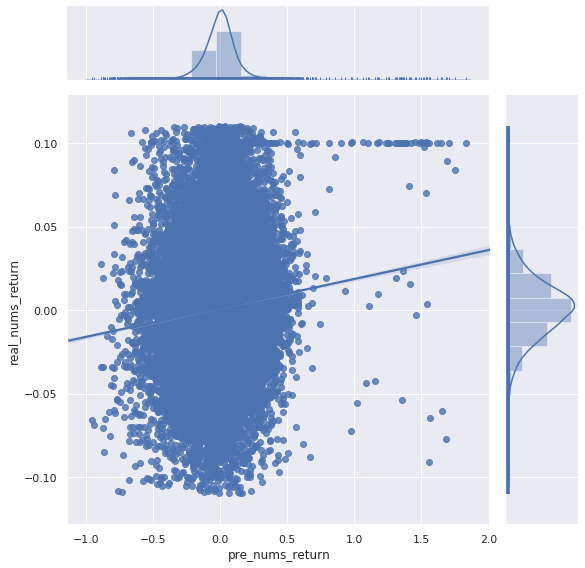

In [14]:

sns.jointplot(
              x = df_r['pre_nums_return'], y = df_r['real_nums_return'],          
              data = df_r,  #设置数据                                 
              kind="reg",                                     
              size = 8, #图表大小(自动调整为正方形))             
              ratio = 5, #散点图与布局图高度比，整型             
              marginal_kws = dict(bins=15, rug =True),              
             )

In [15]:
def segment_mean(x,y,bins):
    x_range = np.linspace(min(x), max(x), bins)
    df = pd.DataFrame({"x":x, "y":y})
    df["x_cut"] = pd.cut(df["x"], x_range)
    

In [16]:
df_r["real_nums_return"].std()

0.023778607164259887

In [17]:
df_r["real_nums_return"].mean()

0.0011744076458725234

In [18]:
for i in range(10):
    temp_df = df_r[df_r["pre_rank"] == i ]
    print(i, np.corrcoef(temp_df["real_nums_return"] - temp_df["market_return"], temp_df["pre_nums_return"])[0,1])

0 0.051216742322292216
1 0.025882638652893617
2 0.015135899614471376
3 0.02355139126927176
4 0.018784805352979578
5 0.0038690592670559756
6 0.005848125127209357
7 0.019583362725760254
8 0.02410134881629712
9 0.1506595718231315


In [19]:
for i in range(10):
    temp_df = df_r[df_r["pre_rank"] == i ]
    print(i, np.corrcoef(temp_df["real_nums_return"], temp_df["pre_nums_return"])[0,1])

0 0.0635251313038026
1 0.03830277872574678
2 0.015473346593872183
3 0.017165511735395007
4 0.013336129487483929
5 -0.003944664706670832
6 -0.0022985406044190877
7 0.012320647945404726
8 0.02787506128751989
9 0.13478077330100327


In [20]:
np.corrcoef(df_r["rank"], df_r["pre_rank"])[0,1]

0.1031087873031835

In [21]:
np.corrcoef(np.array(all_nums_return) - np.array(all_market_return_list) , all_nums_p_return)[0,1]

0.1098993604462877

In [22]:
np.corrcoef(np.array(all_nums_return) , all_nums_p_return)[0,1]

0.09569388983253144

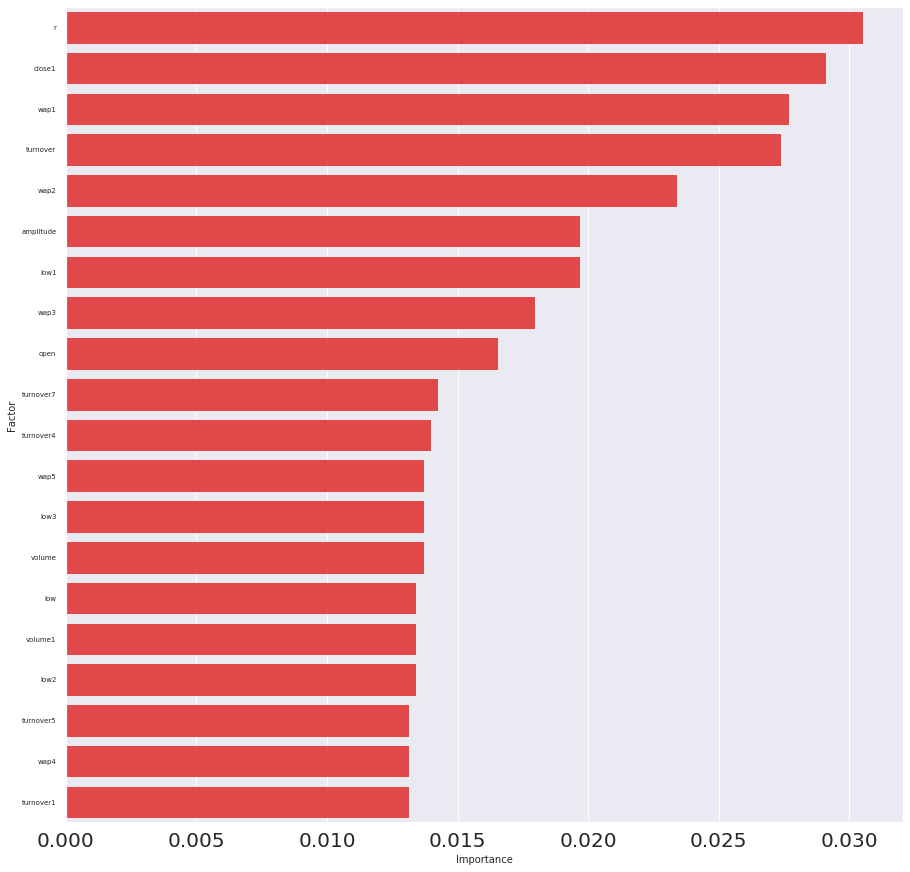

In [41]:
plt.rcParams['figure.figsize'] = (15, 15)
plt.tick_params(labelsize=20)
f_importance_bar(importance_dic)

In [24]:
df_r

,real_nums_return,pre_nums_return,rank,pre_rank,limit_tag,market_return,time_list
0,-0.023552,0.122476,1.0,9,0,-0.010063,2014-01-02
1,-0.009534,0.028696,5.0,6,0,-0.010063,2014-01-02
2,0.000000,0.108214,6.0,9,0,-0.010063,2014-01-02
3,-0.023729,-0.031406,1.0,3,0,-0.010063,2014-01-02
4,0.026820,-0.160294,9.0,0,0,-0.010063,2014-01-02
...,...,...,...,...,...,...,...
115708,0.013208,0.066466,6.0,6,0,0.010976,2014-12-31
115709,-0.012314,-0.033594,2.0,2,0,0.010976,2014-12-31
115710,-0.034688,-0.036348,0.0,2,0,0.010976,2014-12-31
115711,-0.072329,0.098062,0.0,8,0,0.010976,2014-12-31


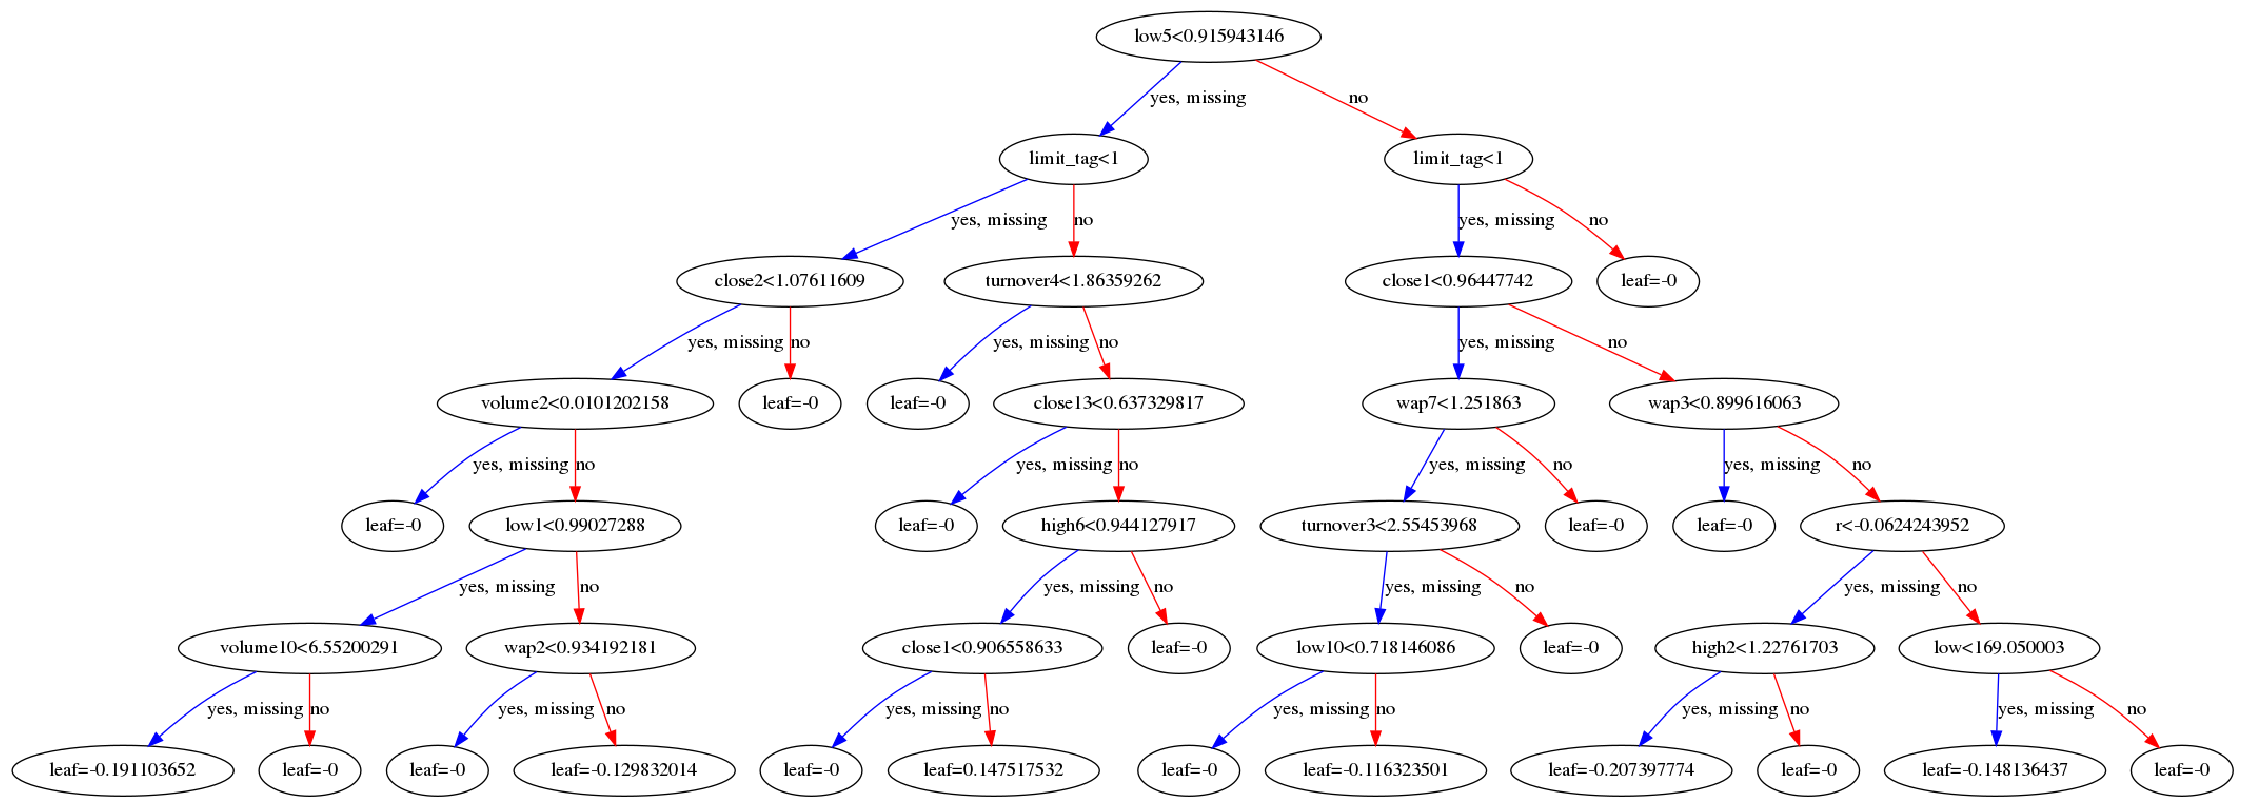

In [25]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=0)
plt.show()

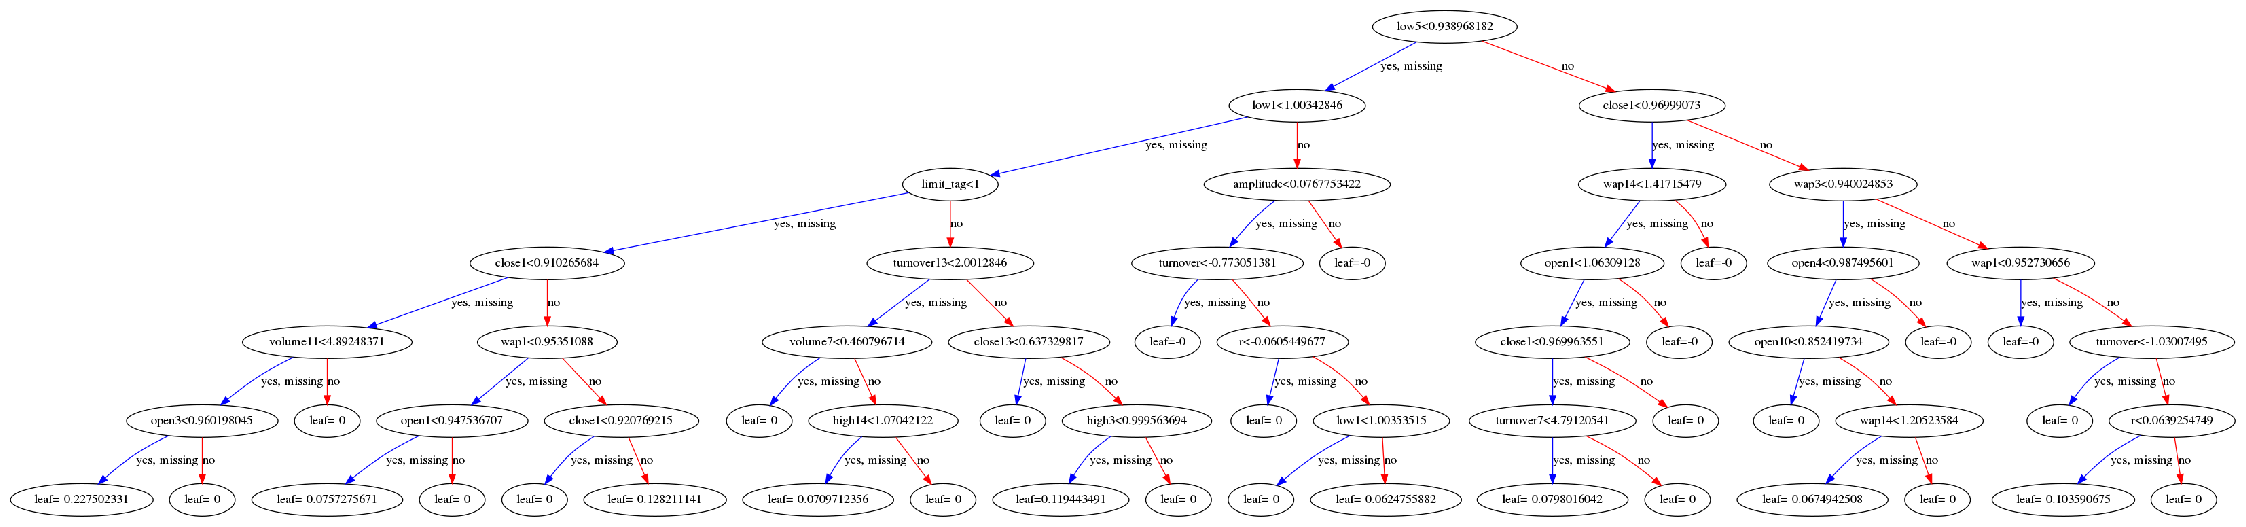

In [26]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=1)
plt.show()

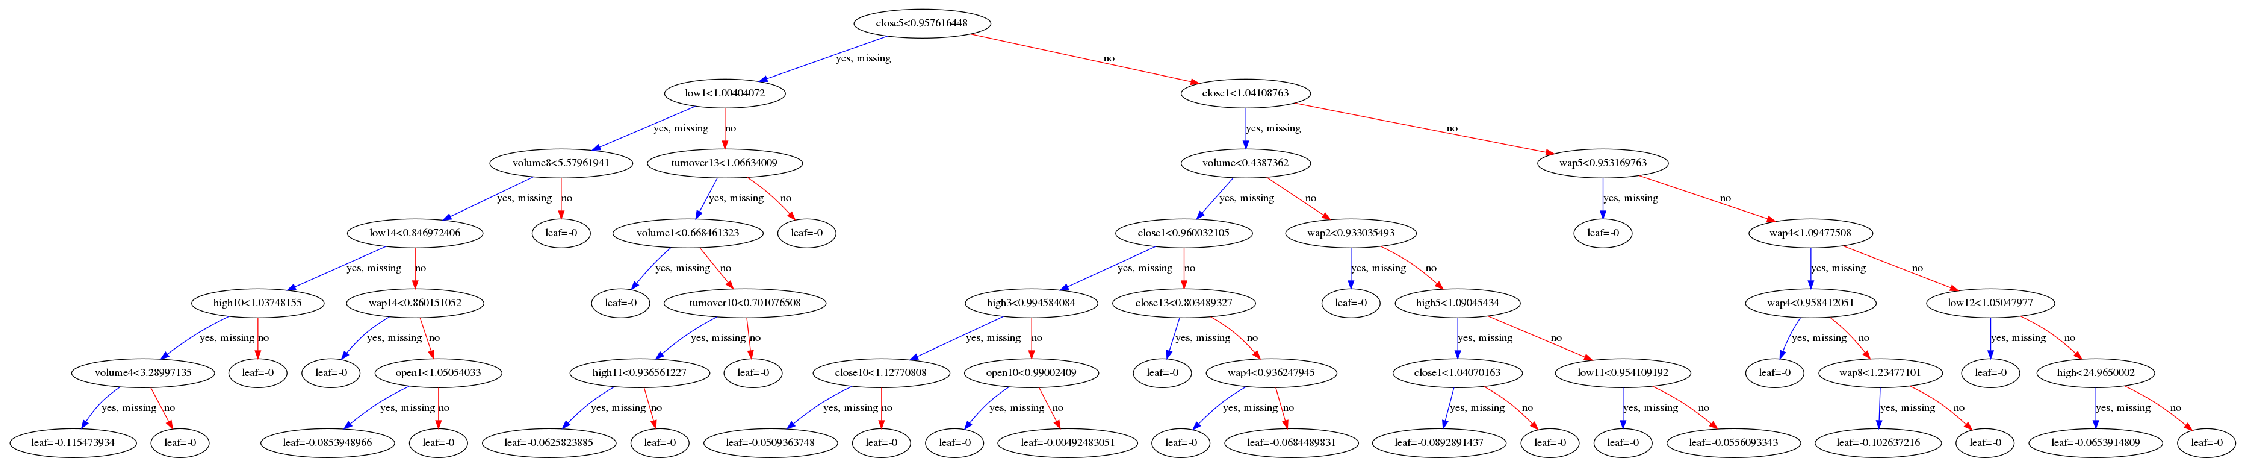

In [27]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=2)
plt.show()

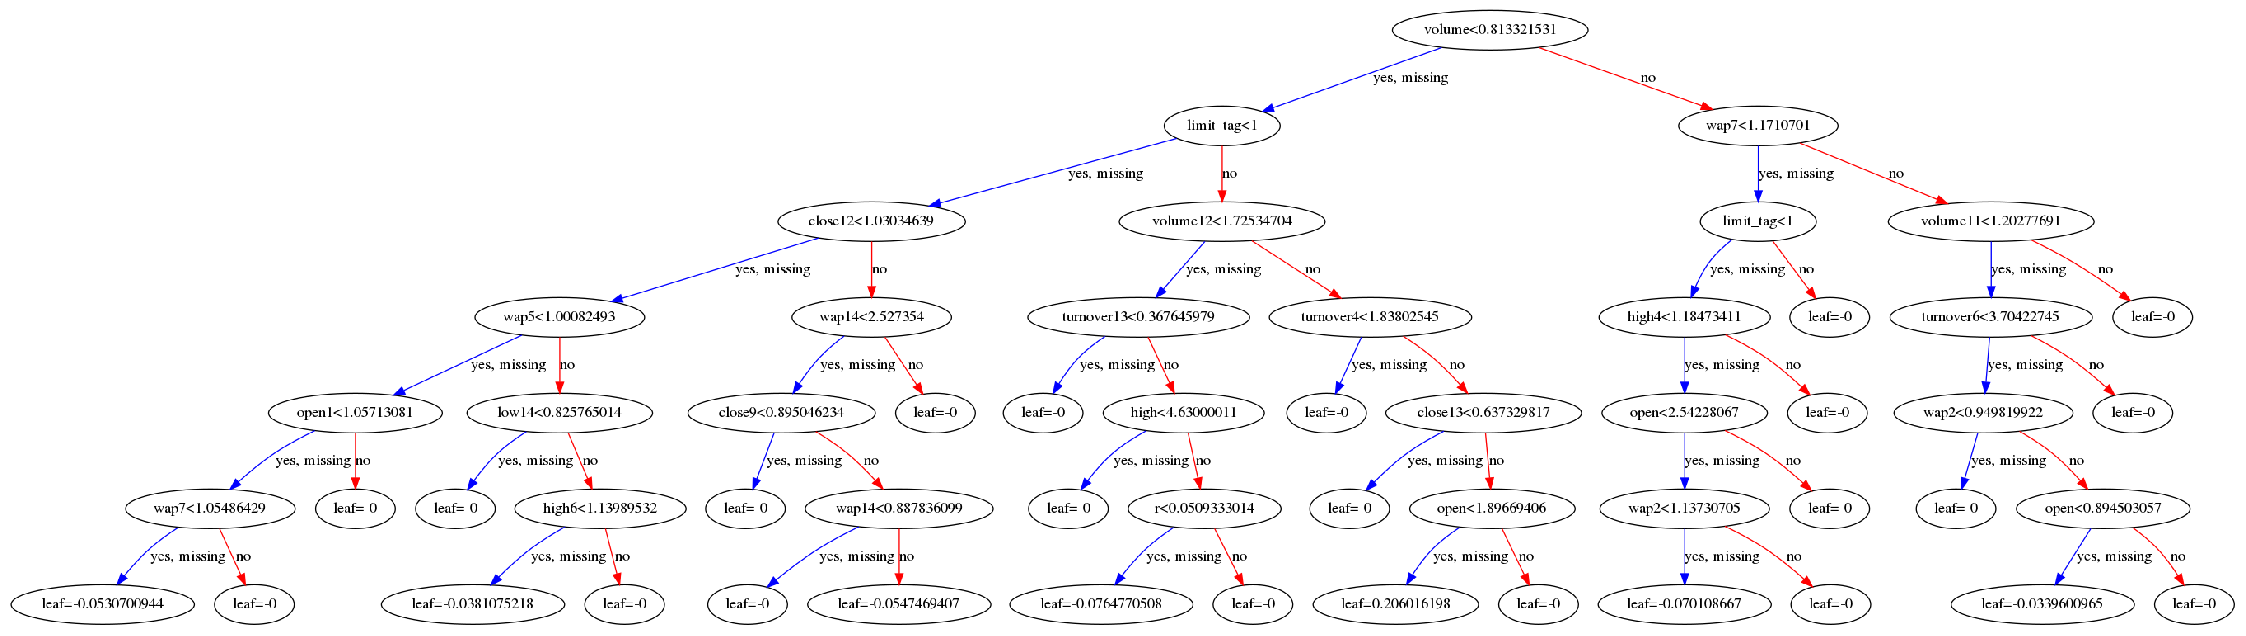

In [28]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=3)
plt.show()

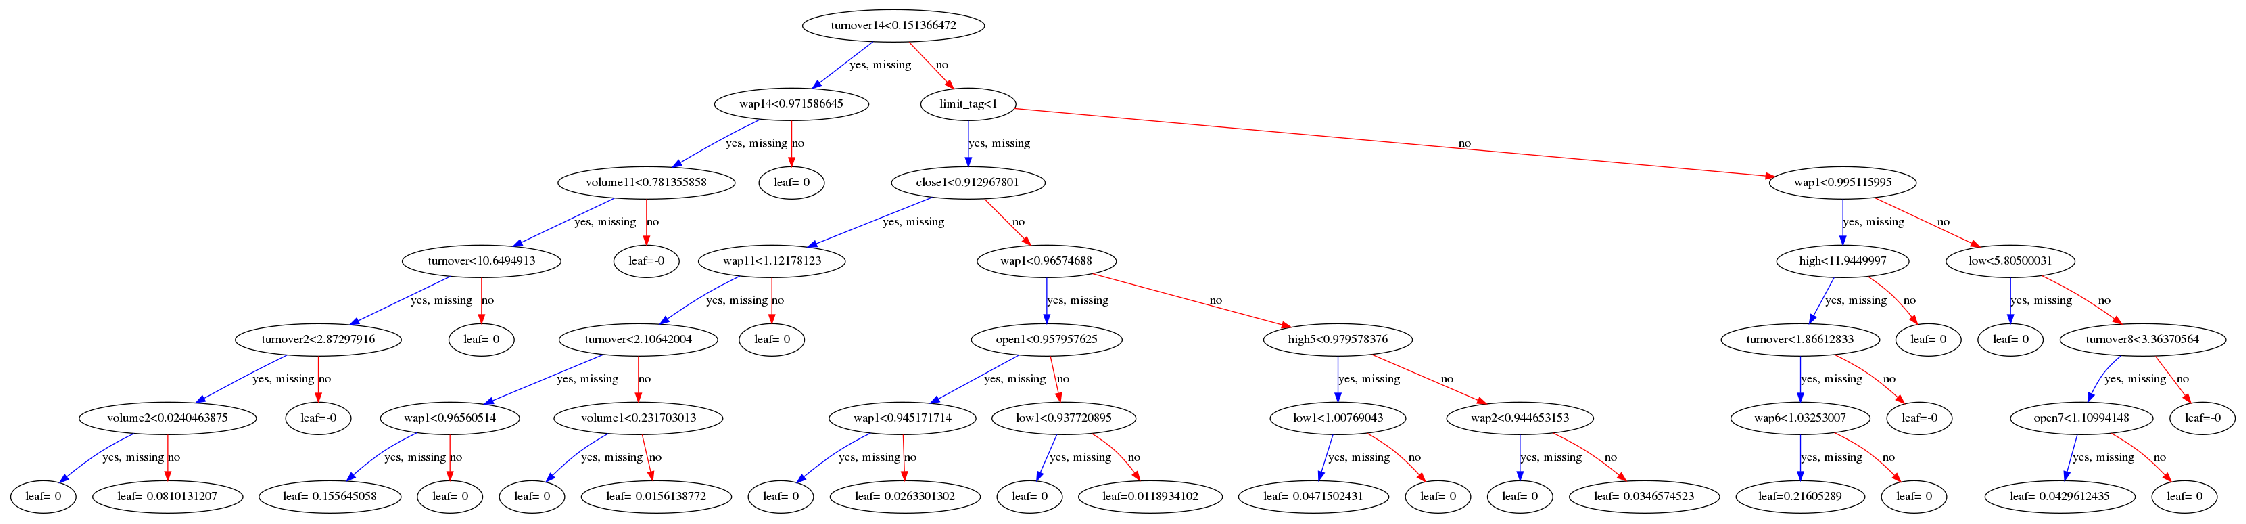

In [29]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=4)
plt.show()

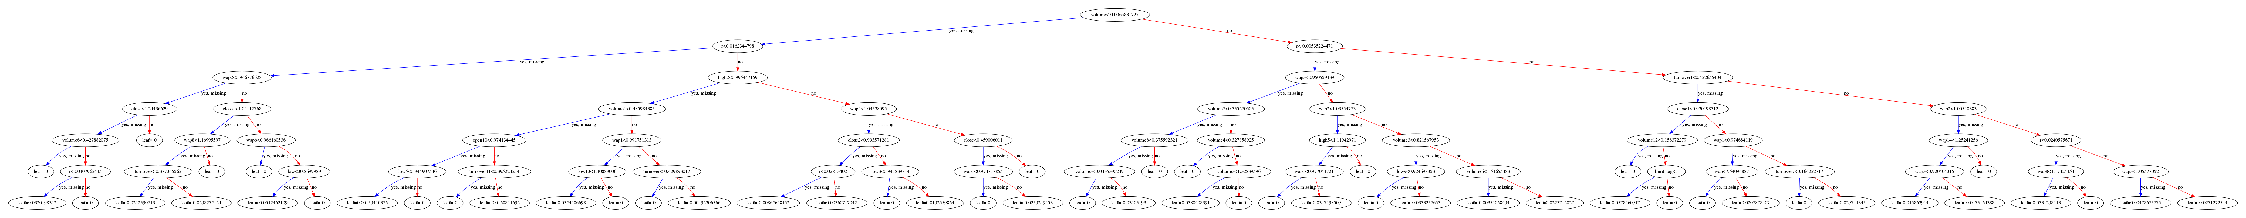

In [30]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=5)
plt.show()

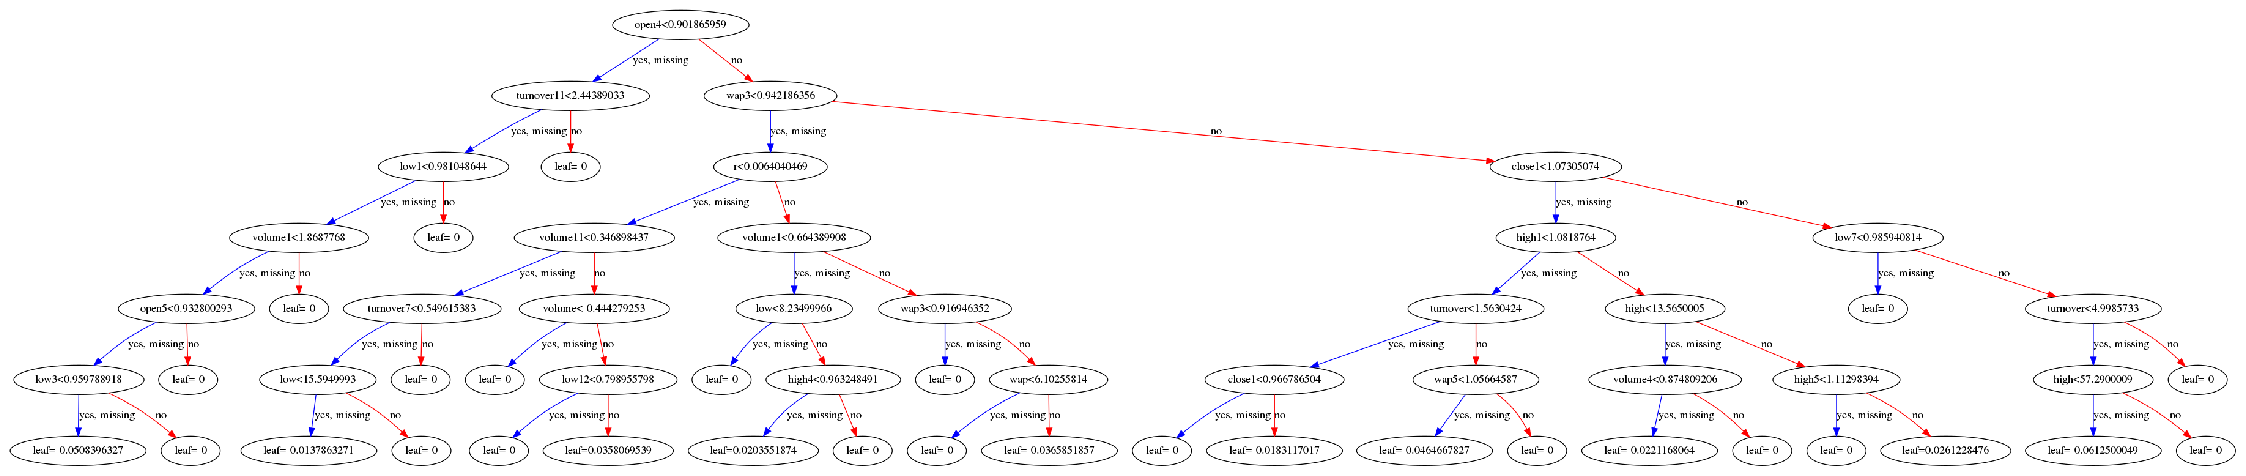

In [31]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=6)
plt.show()

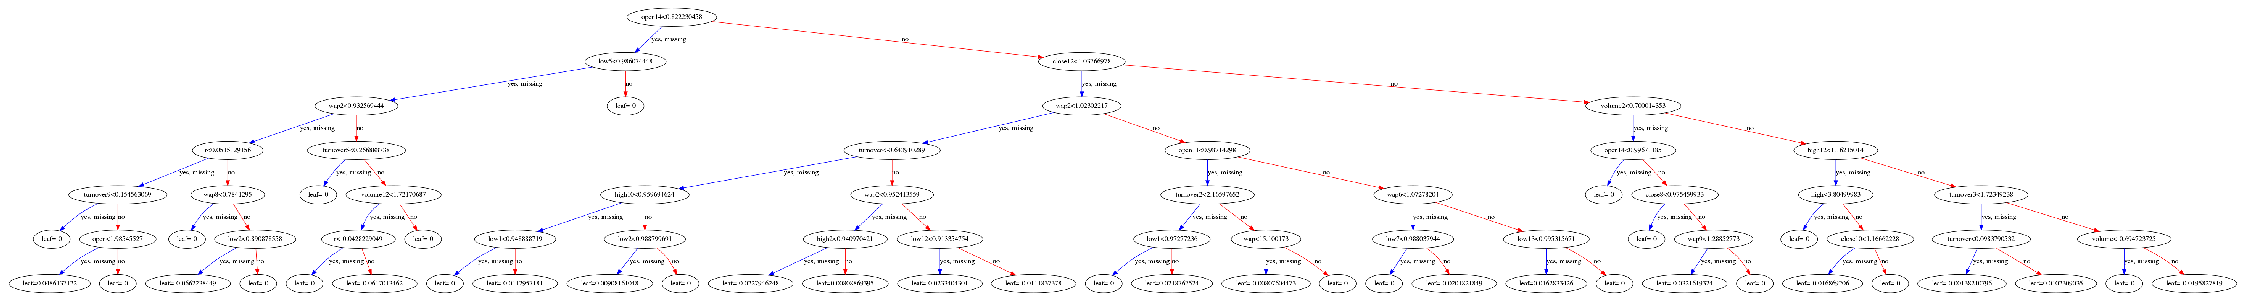

In [32]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=7)
plt.show()

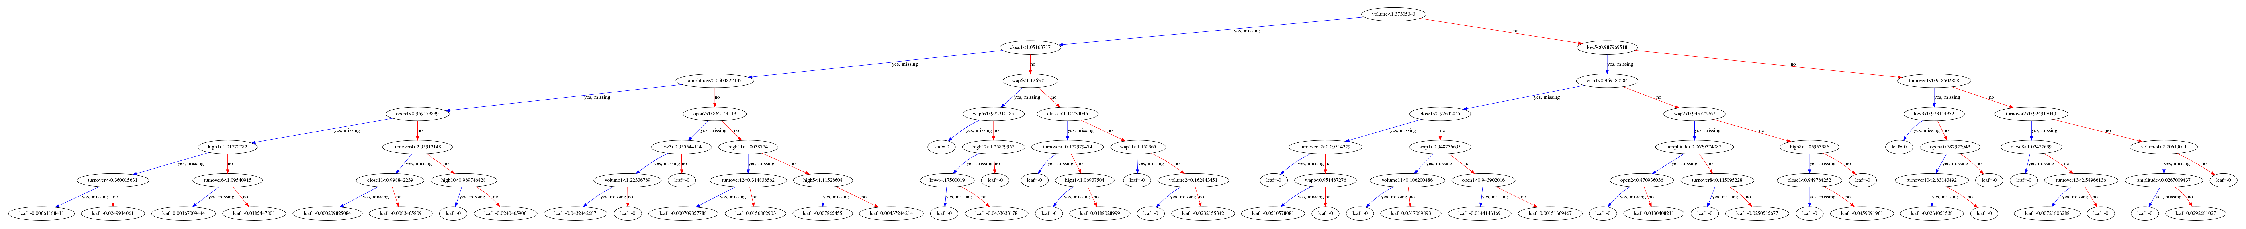

In [33]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=8)
plt.show()

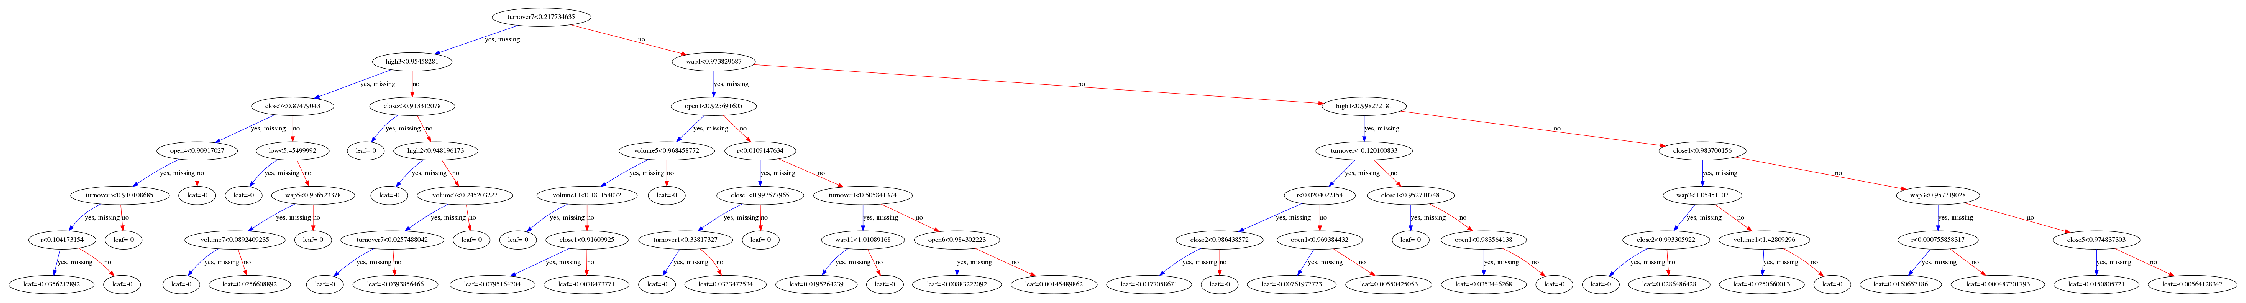

In [34]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=9)
plt.show()

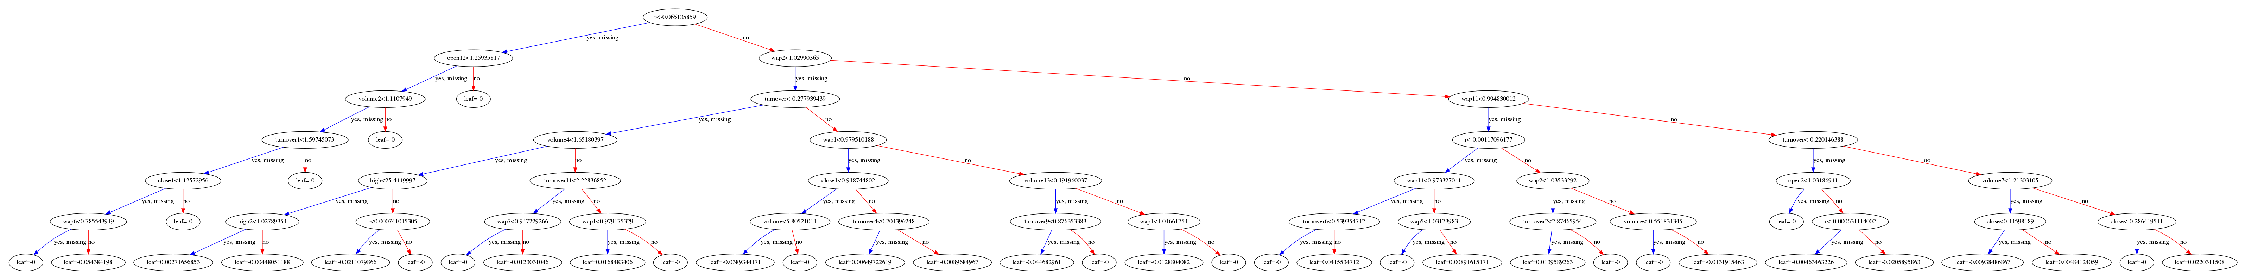

In [35]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=10)
plt.show()

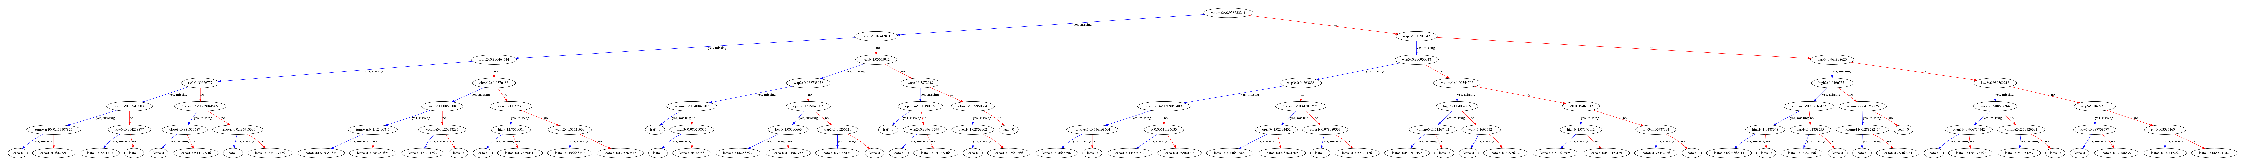

In [36]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=11)
plt.show()